<a href="https://colab.research.google.com/github/fernandofsilva/thesis/blob/main/Options_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
#@title Loading the Libraries
import pandas as pd
import numpy as np
import math

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

In [3]:
#@title Loading the data quote from B3
raw_data = pd.read_csv('/content/drive/My Drive/Datasets/cotacao.csv.gz')
raw_data.head()

,TIPREG,DATPRG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,MODREF,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES
0,1,2015-01-02,2,AAPL34,10,APPLE,DRN,NaN,R$,29.65,29.65,29.45,29.61,29.45,29.20,0.00,2,32300,9.564350e+05,0.0,0,9999-12-31,1,0,BRAAPLBDR004,111
1,1,2015-01-02,2,ABCB4,10,ABC BRASIL,PN EJS N2,NaN,R$,12.85,12.85,12.35,12.54,12.55,12.55,12.56,531,117100,1.469337e+06,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
2,1,2015-01-02,96,ABCB4F,20,ABC BRASIL,PN EJS N2,NaN,R$,12.83,12.83,12.48,12.69,12.48,12.53,12.86,5,208,2.641260e+03,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
3,1,2015-01-02,12,ABCP11,10,FII ABC IMOB,CI ER,NaN,R$,9.72,9.72,8.01,9.64,9.64,9.31,9.64,9,496,4.781490e+03,0.0,0,9999-12-31,1,0,BRABCPCTF000,231
4,1,2015-01-02,2,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,16.14,16.56,15.77,16.08,16.01,15.91,16.01,21543,19110800,3.073420e+08,0.0,0,9999-12-31,1,0,BRABEVACNOR1,106


# PETR4

In [4]:
#@title Filtering the data to a subset (PETR4)
# Filter data
spot = raw_data[raw_data['CODNEG'] == 'PETR4']

# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'PREULT': 'S',
    'VOLTOT': 'volume'
}

# Rename the columns and subset
spot = spot.rename(columns=dict_ref)
spot = spot[dict_ref.values()]

# Format and subset date
spot['date'] = pd.to_datetime(spot['date'])
spot = spot.sort_values(by='date')
spot.index = spot['date']
spot = spot.drop(['date'], axis=1)

spot.head()

,S,volume
date,,
2015-01-02,9.36,467547925.0
2015-01-05,8.61,674783884.0
2015-01-06,8.33,706839884.0
2015-01-07,8.67,733268924.0
2015-01-08,9.18,754338635.0


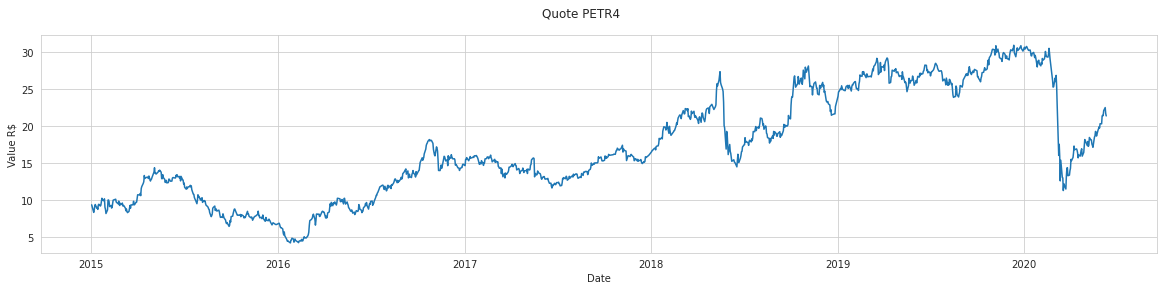

In [29]:
#@title Plot the selected data
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Quote PETR4')
ax.plot(spot['S'])
ax.set_ylabel('Value R$')
ax.set_xlabel('Date')
plt.show()

# Options

In [7]:
#@title Filter and format options data
# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'CODNEG': 'option',
    'PREULT': 'value',
    'PREEXE': 'X',
    'DATVEN': 'expire',
    'TPMERC': 'option_type'
}

# Rename the columns
option = raw_data.rename(columns=dict_ref)

# Filter options data
option = option[option['option_type'].isin([70, 80])]
option = option[option['option'].str.startswith('PETR')]
option = option[dict_ref.values()]

# Dict symbol type
TPMERC = {70: 'call', 80: 'put'}

# Replace options types
option['option_type'] = option['option_type'].replace(TPMERC)
option.head()

,date,option,value,X,expire,option_type
915,2015-01-02,PETRA1,0.13,10.66,2015-01-19,call
916,2015-01-02,PETRA10,1.00,8.61,2015-01-19,call
917,2015-01-02,PETRA11,0.02,21.00,2015-01-19,call
918,2015-01-02,PETRA12,0.02,12.91,2015-01-19,call
919,2015-01-02,PETRA13,0.01,13.91,2015-01-19,call


In [8]:
#@title Calculate the T variable
# Get unique days
workday = pd.DataFrame({'day': option['date'].unique()})
workday['day'] = pd.to_datetime(workday['day'])
workday = workday.sort_values(by='day')

# Create T
T = list()

for index, row in option.iterrows():
    T.append(workday[(workday['day'] >= row.date) & (workday['day'] <= row.expire)].shape[0] - 1)

option['T'] = T
option['T'] = option['T'] / 252

# Format and subset date
option['date'] = pd.to_datetime(option['date'])
option['expire'] = pd.to_datetime(option['expire'])
option = option.sort_values(by='date')

# Set index
option.index = option['date']
option = option.drop(['date'], axis=1)

option.head()

,option,value,X,expire,option_type,T
date,,,,,,
2015-01-02,PETRA1,0.13,10.66,2015-01-19,call,0.043651
2015-01-02,PETRL44,0.50,17.00,2015-12-21,call,0.952381
2015-01-02,PETRM1,1.34,10.66,2015-01-19,put,0.043651
2015-01-02,PETRM10,0.19,8.61,2015-01-19,put,0.043651
2015-01-02,PETRM12,3.58,12.91,2015-01-19,put,0.043651


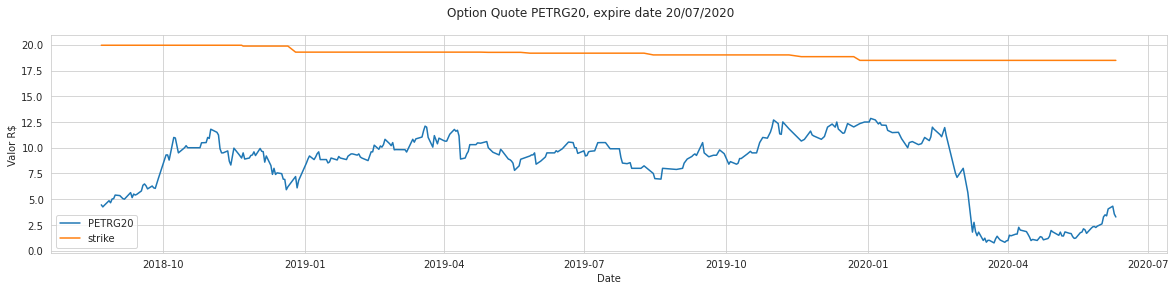

In [28]:
#@title Plot Option data example
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Option Quote PETRG20, expire date 20/07/2020')
ax.plot(option.loc[(option['option'] == 'PETRG20') & (option['expire'] == '2020-07-20'), 'value'], label='PETRG20')
ax.plot(option.loc[(option['option'] == 'PETRG20') & (option['expire'] == '2020-07-20'), 'X'], label='strike')
ax.set_ylabel('Valor R$')
ax.set_xlabel('Date')
ax.legend()
plt.show()

# CDI

In [22]:
#@title Load data from Tresuries Brasil 
cdi = pd.read_csv('/content/drive/My Drive/Datasets/cdi.csv', usecols=['date', 'cdi'])

In [23]:
#@title Format CDI Data
# Format and subset date
cdi['date'] = pd.to_datetime(cdi['date'], format='%d/%m/%y')
cdi = cdi.sort_values(by='date')

# Filter using the first date
cdi = cdi[cdi['date'].dt.month != cdi['date'].dt.month.shift(1)]

# Create date range
date = pd.DataFrame({'date': pd.date_range(start='1/1/2015', end='12/31/2020')})

# Merge with cdi
date = date.merge(right=cdi, how='left', on='date')

# Fill Nan
date['cdi'] = date['cdi'].fillna(method='ffill')
cdi = date.dropna()

# Create index
cdi = cdi.rename(columns={'cdi': 'r'})
cdi.index = cdi['date']
cdi = cdi.drop(['date'], axis=1)
cdi.head()

,r
date,
2015-01-02,11.57
2015-01-03,11.57
2015-01-04,11.57
2015-01-05,11.57
2015-01-06,11.57


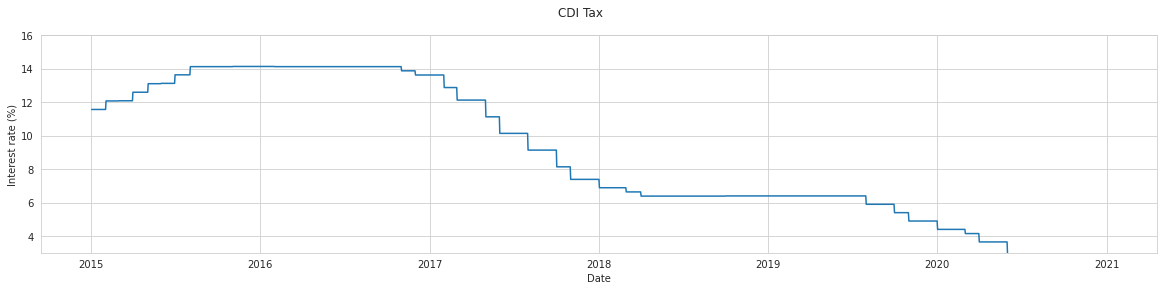

In [27]:
#@title Plot CDI Data
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('CDI Tax')
ax.plot(cdi)
ax.set_ylabel('Interest rate (%)')
ax.set_ylim(3, 16)
ax.set_xlabel('Date')
plt.show()

# GARCH (1,1)

In [35]:
#@title Calculate PETR4 returns
spot['return'] = np.log(spot['S'] / spot['S'].shift(1))
spot = spot.dropna()
spot['var'] = spot['return']**2
spot.head()

,S,volume,return,var
date,,,,
2015-01-05,8.61,674783884.0,-0.083521,0.006976
2015-01-06,8.33,706839884.0,-0.033061,0.001093
2015-01-07,8.67,733268924.0,0.040005,0.001600
2015-01-08,9.18,754338635.0,0.057158,0.003267
2015-01-09,9.40,460371734.0,0.023682,0.000561


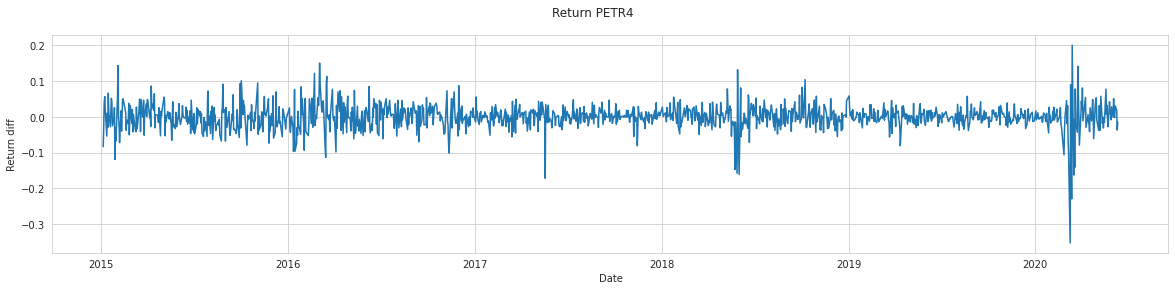

In [36]:
#@title Plot Returns PETR4
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Return PETR4')
ax.plot(spot['return'])
ax.set_ylabel('Return diff')
ax.set_xlabel('Date')
plt.show()

In [ ]:
#@title Pip install arch package
!pip install arch

In [39]:
#@title Garch Modeling
from arch import arch_model

am = arch_model(spot['return'], p=1, o=0, q=1)
res = am.fit(update_freq=5)
garch = res.conditional_volatility * math.sqrt(252) * 100
garch = garch.rename("sigma")
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2818.1945447644266
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                2818.19
Distribution:                  Normal   AIC:                          -5628.39
Method:            Maximum Likelihood   BIC:                          -5607.58
                                        No. Observations:                 1343
Date:                Mon, Nov 02 2020   Df Residuals:                     1339
Time:                        20:49:01   Df Model:                            4
                                  Mean Model                                 
 

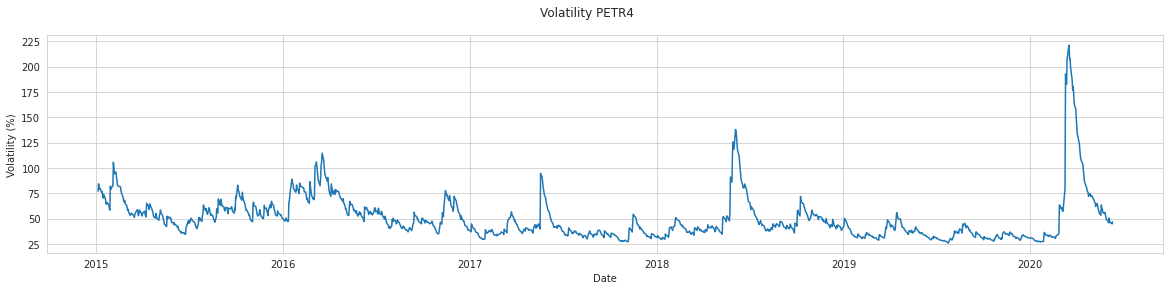

In [42]:
#@title Plot Volatility
fig, axs = plt.subplots(figsize=(20, 4))
fig.suptitle('Volatility PETR4')
axs.plot(garch)
axs.set_ylabel('Volatility (%)')
axs.set_xlabel('Date')
plt.show()

# Merge

In [31]:
#@title Merge data PETR4, Options, CDI, GARCH
data = option.merge(right=spot, right_index=True, left_index=True)
data = data.merge(right=cdi, right_index=True, left_index=True)
data = data.merge(right=garch, right_index=True, left_index=True)
data = data.rename(columns={'cond_vol': 'vol'})
data.head()

,option,value,X,expire,option_type,T,S,volume,r
date,,,,,,,,,
2015-01-02,PETRA1,0.13,10.66,2015-01-19,call,0.043651,9.36,467547925.0,11.57
2015-01-02,PETRL44,0.50,17.00,2015-12-21,call,0.952381,9.36,467547925.0,11.57
2015-01-02,PETRM1,1.34,10.66,2015-01-19,put,0.043651,9.36,467547925.0,11.57
2015-01-02,PETRM10,0.19,8.61,2015-01-19,put,0.043651,9.36,467547925.0,11.57
2015-01-02,PETRM12,3.58,12.91,2015-01-19,put,0.043651,9.36,467547925.0,11.57


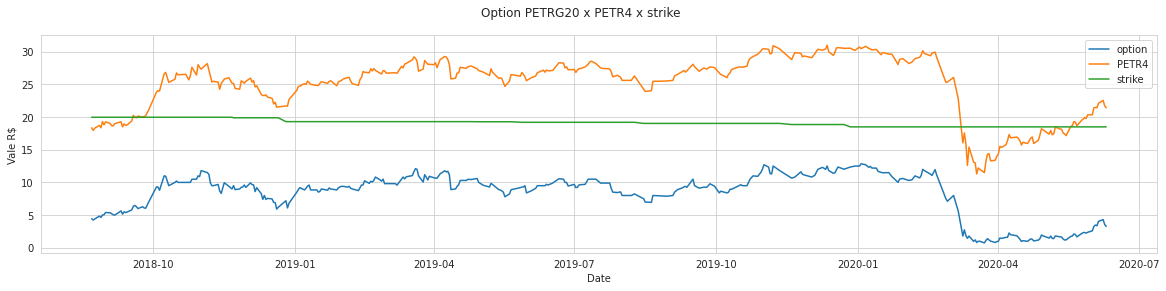

In [33]:
#@title Plot Merge Data
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Option PETRG20 x PETR4 x strike')
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'value'], label='option')
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'S'], label='PETR4')
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'X'], label='strike')
ax.set_ylabel('Vale R$')
ax.set_xlabel('Date')
ax.legend()
plt.show()

# Black-Scholes

In [45]:
#@title Formula
from scipy.stats import norm

# Auxiliary function for d_one risk-adjusted probability
def d11(S, X, T, r, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# Auxiliary function for d_two risk-adjusted probability
def d21(d1, T, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return d1 - sigma * np.sqrt(T)

# Definition of the Black-Scholes delta function
def bs_delta(S, X, T, r, sigma, option_type):
    """Compute the delta of the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the delta value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    if option_type == 'call':
        return norm.cdf(d11(S, X, T, r, sigma))
    elif option_type == 'put':
        return norm.cdf(-d11(S, X, T, r, sigma))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

# Definition of the Black-Scholes European option pricing formula
def black_scholes(S, X, T, r, sigma, option_type):
    """Price a European option using the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the option value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'call':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'put':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

def bs_pandas(row):
    value = black_scholes(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return round(value, 2)

def delta_pandas(row):
    value = bs_delta(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return int(round(value * 100, 0))

data['bs'] = data.apply(bs_pandas, axis=1)
data['delta_bs'] = data.apply(delta_pandas, axis=1)
data.head()

,option,value,X,expire,option_type,T,S,volume,r,sigma,bs,delta_bs
date,,,,,,,,,,,,
2015-01-05,PETRM2,0.02,4.91,2015-01-19,put,0.039683,8.61,674783884.0,11.57,77.210396,0.00,0
2015-01-05,PETRM23,0.79,9.21,2015-01-19,put,0.039683,8.61,674783884.0,11.57,77.210396,0.87,63
2015-01-05,PETRM25,1.13,9.61,2015-01-19,put,0.039683,8.61,674783884.0,11.57,77.210396,1.16,73
2015-01-05,PETRM51,0.15,7.61,2015-01-19,put,0.039683,8.61,674783884.0,11.57,77.210396,0.14,18
2015-01-05,PETRM16,7.13,15.91,2015-01-19,put,0.039683,8.61,674783884.0,11.57,77.210396,7.23,100


# Save to file

In [54]:
#@title
# Save file to Csv
data.to_csv(f'/content/drive/My Drive/Datasets/data_option.csv')